# MNIST Autoencoder
### Directives
* Create the autoencoders using the functional API described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights or not)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)
3. Optional : GAN or VAE


In [ ]:
# Choose Python 3 runtime
#!pip install --upgrade tensorflow

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [ ]:
tf.random.set_seed(42)

In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

(70000, 28, 28)

In [ ]:
#Normalizing data
#As we are reconstructing input, keeping all data as training data as the same will act as test and valid data
X_train = all_data/255

In [ ]:
X_train.shape

(70000, 28, 28)

In [ ]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

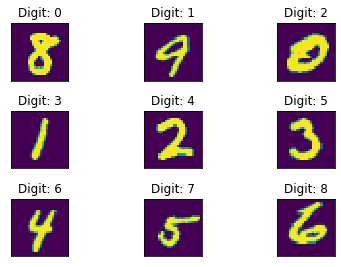

In [ ]:
print_first_9(all_data[-9:])

In [ ]:
#defining function for custom metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
def show_reconstructions(model, images=X_train, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### 1. Stacked Autoencoder

Using Functional API to build a stacked autoencoder.

In [ ]:
keras.backend.clear_session()

inputs = keras.layers.Input(shape=[28, 28])
enc = keras.layers.Flatten()(inputs)
enc = keras.layers.Dense(784, activation="relu")(enc)
enc = keras.layers.Dense(392, activation="relu")(enc)
enc = keras.layers.Dense(196, activation="relu")(enc)

dec = keras.layers.Dense(392, activation="relu")(enc)
dec = keras.layers.Dense(784, activation="sigmoid")(dec)
output = keras.layers.Reshape([28, 28])(dec)

stacked_model = keras.Model(inputs=inputs, outputs=output)

stacked_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[rounded_accuracy])
stacked_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 392)               307720    
                                                                 
 dense_2 (Dense)             (None, 196)               77028     
                                                                 
 dense_3 (Dense)             (None, 392)               77224     
                                                                 
 dense_4 (Dense)             (None, 784)               308112

In [ ]:
#note that x and y would be same set of data here as the goal is to reconstruct the input image.
stacked_history = stacked_model.fit(X_train, X_train, epochs=5)

Epoch 1/5
2188/2188 [==============================] - 15s 6ms/step - loss: 0.1027 - rounded_accuracy: 0.9649
Epoch 2/5
2188/2188 [==============================] - 9s 4ms/step - loss: 0.0780 - rounded_accuracy: 0.9799
Epoch 3/5
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0745 - rounded_accuracy: 0.9824
Epoch 4/5
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0727 - rounded_accuracy: 0.9837
Epoch 5/5
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0715 - rounded_accuracy: 0.9846


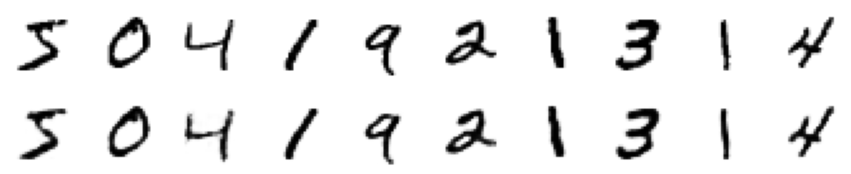

In [ ]:
show_reconstructions(stacked_model)

### 2. Convolutional

- Using convolutional layers for building an autoencoder.
- Encoder part uses maxpooling layer to compress image.
- Decoder part uses upsampling layer to decompress image.

In [ ]:
keras.backend.clear_session()

inputs = keras.layers.Input(shape=[28, 28, 1])
enc1 = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu")(inputs) 
enc2 = keras.layers.MaxPooling2D(pool_size=2, padding="SAME")(enc1)
enc3 = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu")(enc2)
enc4 = keras.layers.MaxPooling2D(pool_size=2, padding="SAME")(enc3)
enc5 = keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu")(enc4)
enc6 = keras.layers.MaxPooling2D(pool_size=1, padding="SAME")(enc5)

dec1 = keras.layers.Conv2D(16, kernel_size=2, padding="SAME", activation="relu")(enc6)
dec2 = keras.layers.UpSampling2D(size=(1,1))(dec1)
dec3 = keras.layers.Conv2D(16, kernel_size=2, padding="SAME", activation="relu")(dec2)
dec4 = keras.layers.UpSampling2D(size=(2,2))(dec3)
dec5 = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="sigmoid")(dec4)
dec6 = keras.layers.UpSampling2D(size=(2,2))(dec5)
dec7 = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="sigmoid")(dec6)
output = keras.layers.Reshape([28, 28])(dec1)

conv_model = keras.Model(inputs=inputs, outputs=output)

conv_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[rounded_accuracy])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [ ]:
#note that x and y would be same set of data here as the goal is to reconstruct the input image.
conv_history = conv_model.fit(X_train, X_train, epochs=6)

Epoch 1/6
2188/2188 [==============================] - 11s 4ms/step - loss: 0.2770 - rounded_accuracy: 0.8730
Epoch 2/6
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2251 - rounded_accuracy: 0.8951
Epoch 3/6
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2132 - rounded_accuracy: 0.9053
Epoch 4/6
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2113 - rounded_accuracy: 0.9077
Epoch 5/6
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2096 - rounded_accuracy: 0.9085
Epoch 6/6
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2212 - rounded_accuracy: 0.9034


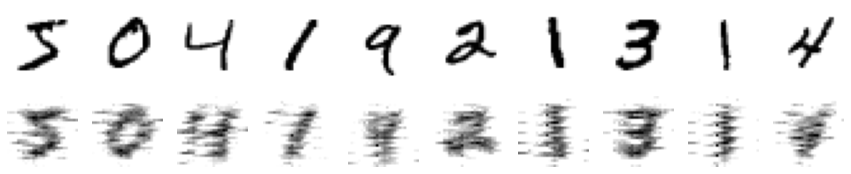

In [ ]:
show_reconstructions(conv_model)

### 3. VAE

Using Functional API to build variational autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="relu")(z)
z = keras.layers.Dense(100, activation="relu")(z)


codings_mean = keras.layers.Dense(10)(z)
codings_log_var = keras.layers.Dense(10)(z)

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = keras.layers.Dense(150, activation="relu")(x)
x = keras.layers.Dense(784, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)


In [ ]:
vae_model = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
vae_model.add_loss(K.mean(latent_loss) / 784.)

vae_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[rounded_accuracy])
vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model_1 (Functional)           [(None, 10),         134870      ['input_2[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 model_2 (Functional)           (None, 28, 28)       134634      ['model_1[0][2]']                
                                                                                            

In [ ]:
#note that x and y would be same set of data here as the goal is to reconstruct the input image.
vae_history = vae_model.fit(X_train, X_train, epochs=5, batch_size=128)

Epoch 1/5
547/547 [==============================] - 3s 5ms/step - loss: 0.2288 - rounded_accuracy: 0.8978
Epoch 2/5
547/547 [==============================] - 3s 5ms/step - loss: 0.1689 - rounded_accuracy: 0.9360
Epoch 3/5
547/547 [==============================] - 3s 5ms/step - loss: 0.1580 - rounded_accuracy: 0.9432
Epoch 4/5
547/547 [==============================] - 3s 5ms/step - loss: 0.1527 - rounded_accuracy: 0.9466
Epoch 5/5
547/547 [==============================] - 3s 5ms/step - loss: 0.1497 - rounded_accuracy: 0.9486


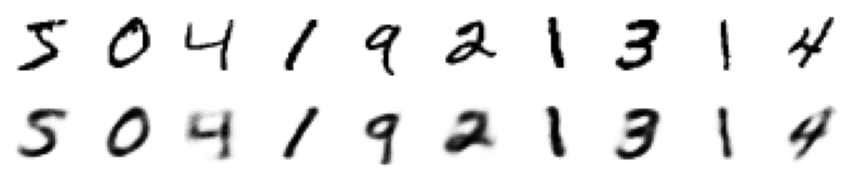

In [ ]:
show_reconstructions(vae_model)